# Tutorial: NGEM - Neural Graph Error Mitigation

In [13]:
import json
import glob

import numpy as np

from qiskit.providers.fake_provider import FakeLima

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator

### (Optional) Generate dataset

In [2]:
lima = FakeLima()

N_FILES = 5
N_ENTRIES_PER_FILE = 100

for i in tqdm_notebook(range(N_FILES)):
    generator = exp_value_generator(
        backend=lima,
        n_qubits=5,
        circuit_depth=2,
        pauli_terms=1,
        max_entries=N_ENTRIES_PER_FILE
    )
    with tqdm_notebook(total=N_ENTRIES_PER_FILE) as t:
        entries = []
        for entry in generator:
            entries.append(entry.to_dict())
            t.update(1)
            
        with open(f"./data/random/{i}.json", "w") as f:
            json.dump(entries, f)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Load data

In [3]:
max_files_to_use = 5
train_size = 4

data_paths = glob.glob("./data/random/**.json")[:max_files_to_use]

BATCH_SIZE = 10

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[:train_size],
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[train_size:],
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[336, 28], edge_index=[2, 786], edge_attr=[450, 3], y=[10, 1], noisy=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], batch=[336], ptr=[11])


### Define model

In [7]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        n_qubits: int,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        
        self.cheb_conv1 = ChebConv(num_node_features, hidden_channels, K=3)
        self.cheb_conv2 = ChebConv(hidden_channels, 1, K=2)

        self.sage_conv1 = SAGEConv(num_node_features, hidden_channels)
        self.sage_conv2 = SAGEConv(hidden_channels, 1)
        
        self.obs_seq = torch.nn.Sequential(
            Linear(n_qubits * 4 + 1, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )
        
        self.body_seq = torch.nn.Sequential(
            Linear(6, hidden_channels),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        # GCN
        graph = self.conv1(nodes, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv2(graph, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv3(graph, edge_index)
        graph = global_mean_pool(graph, batch)
        
        # Cheb
        cheb = self.cheb_conv1(nodes, edge_index).relu()
        cheb = dropout(cheb, training=self.training, p=0.2)
        cheb = self.cheb_conv2(cheb, edge_index)
        cheb = global_mean_pool(cheb, batch)
        
        # Sage
        sage = self.sage_conv1(nodes, edge_index).relu()
        sage = dropout(sage, training=self.training, p=0.2)
        sage = self.sage_conv2(sage, edge_index)
        sage = global_mean_pool(sage, batch)
        
        obs = self.obs_seq(observable)
        obs = torch.mean(obs, dim=1)
        
        merge = torch.cat((
            graph, 
            cheb,
            sage,
            obs,
            circuit_depth,
            exp_value
        ), dim=1)

        return self.body_seq(merge)

### Train

In [8]:
model = ExpValCircuitGraphModel(
    n_qubits=5,
    num_node_features=28, 
    hidden_channels=10
)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.5, 
                              patience=20, 
                              verbose=True, 
                              min_lr=0.000001)

In [11]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, data.y)        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(data.noisy, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

### Visualisation

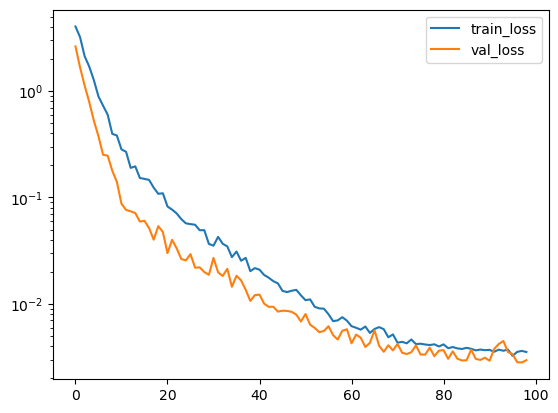

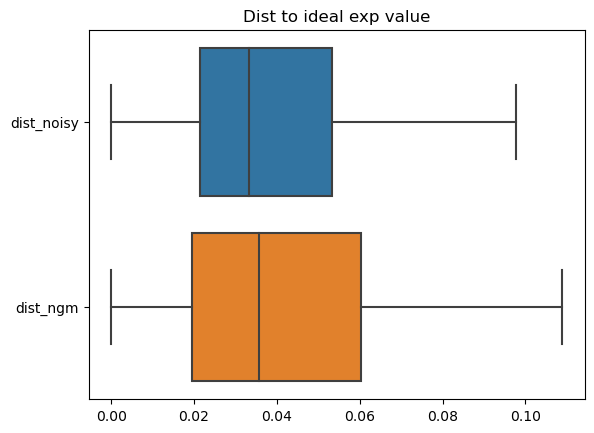

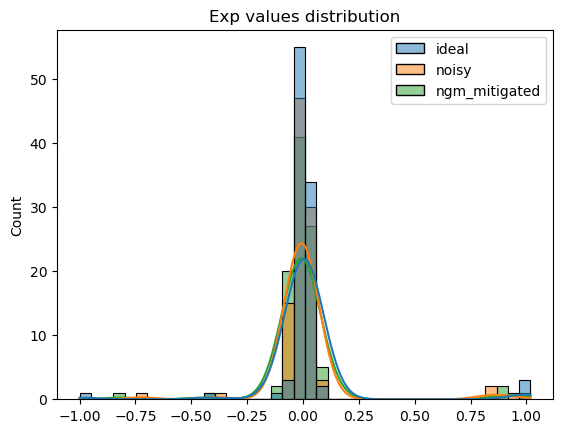

In [17]:

plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()